In [1]:
from __future__ import annotations
from itertools import chain
from collections import defaultdict
from tqdm import tqdm
import os
from build import get_names
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import re
import networkx as nx
import networkx.algorithms.community as nx_comm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

datapath = "../data"
localdatapath = "../local_data"

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300

In [2]:
df = pd.read_csv(os.path.join(localdatapath, "book.csv"), header=0, index_col=0)
df["names"] = df.apply(lambda r: eval(r["names"]), axis=1)
df['selftext'] = df['text']
df = df.drop(['text'], axis = 1)
df.iloc[3]

book                                                        0
title                                                DAENERYS
names       [Daenerys Targaryen, Jorah Mormont, Viserys Ta...
selftext    DAENERYS\n\n\n\n\n\nHer brother held the gown ...
Name: 3, dtype: object

In [112]:
df_reddit = pd.read_csv(os.path.join(localdatapath, "asoiaf_data_cleaned.csv"), header=0, index_col=0)
df_reddit["names"] = df_reddit.apply(lambda r: eval(r["names"]), axis=1)
df_reddit = df_reddit[0:2500]

In [113]:
url = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
num = r"\d"
punct = r"['""!(?.,:;*&_)#\-=\\·\[“”]"
stop_ord = list(stopwords.words("english")) 
stop_ord.extend(['would' , 'could', 'one', 'ser','twoiaf,', 'said','ned','…','“i','“the',' *',' -', 'like','–', '&gt;','*','|','--','•','jon','dany','bran'])
stop_ord = set(stop_ord)
stops = set(stopwords.words("english"))

def tokenize_sub(row):
    """ 
    Takes in a row of the GME submissions in Pandas dataframe and splits the selftext into tokens that are lower-cased
    and filtered for numbers, stop words, punctuations and URL's. We do not perform stemming and lemmatization as
    the full words are easier to understand in analysis than just using stems.
    """
    sub = row["selftext"]
    tokens = list()
    for w in sub.split():
        w = w.strip().lower()
        if re.search(num, w) or re.search(punct, w) or re.search(url, w) or w in stop_ord:
            continue
        w = re.sub(r"[^a-z]", "", w) 
        tokens.append(w)
    return tokens

df_reddit["tokens"] = df_reddit.apply(tokenize_sub, axis=1)
df["tokens"] = df.apply(tokenize_sub, axis=1)

In [114]:
namedict  = get_names("../data")
L = [name for name in namedict.values()]
nameset  = [name.lower() for name in list(chain(*L))]
nameset  = set(nameset)

In [115]:
DATAFRAME = df_reddit # df for books

In [116]:
docs = {k: list() for k in list(namedict)}
for names, tokens in zip(DATAFRAME["names"], DATAFRAME["tokens"]):
    if names:
        
        for i in range(len(names)):
            docs[names[i]] += tokens

In [117]:
chosen = list(namedict.keys())
N = len(chosen)
doc_tfs = dict()
word_docs = defaultdict(lambda: set())
for stock in chosen:
    doc = docs[stock]
    M = len(doc)
    tfs = dict()
    for w in tqdm(set(doc)):
        tfs[w] = doc.count(w) / M
        word_docs[w].add(stock)
    print(
        f"Top 5 TF-terms for {stock.upper()}: \t" + ", ".join(
            list(reversed(sorted(tfs, key=tfs.get)))[:5]
        )
    )
    doc_tfs[stock] = tfs
doc_freqs = {w: len(d) for w, d in word_docs.items()}
doc_idfs = {
    stock: {w: np.log(N/(doc_freqs[w]+1)) for w in set(docs[stock])} 
        for stock in chosen
    }

  1%|▍                                                                             | 66/11372 [00:00<00:17, 659.81it/s]

Top 5 TF-terms for EDDARD 'NED' STARK: 	king, even, stark, think, first


  0%|▎                                                                             | 53/11641 [00:00<00:22, 524.30it/s]

Top 5 TF-terms for ROBERT BARATHEON: 	even, king, robert, think, know


  1%|▊                                                                            | 104/10290 [00:00<00:19, 520.33it/s]

Top 5 TF-terms for JAIME LANNISTER: 	jaime, tyrion, think, even, cersei


  0%|▎                                                                             | 55/12643 [00:00<00:22, 549.81it/s]

Top 5 TF-terms for CATELYN STARK: 	stark, house, know, think, also


  0%|▏                                                                             | 35/15060 [00:00<00:43, 346.39it/s]

Top 5 TF-terms for CERSEI LANNISTER: 	cersei, think, tyrion, even, know


  4%|██▉                                                                          | 280/7440 [00:00<00:05, 1355.63it/s]

Top 5 TF-terms for DAENERYS TARGARYEN: 	think, even, king, also, know


  3%|██                                                                           | 228/8734 [00:00<00:07, 1128.47it/s]

Top 5 TF-terms for JORAH MORMONT: 	rodrik, also, targaryen, know, theon


  0%|▏                                                                             | 27/16471 [00:00<01:02, 264.57it/s]

Top 5 TF-terms for VISERYS TARGARYEN: 	targaryen, aegon, king, prince, even


  3%|██▌                                                                          | 255/7755 [00:00<00:05, 1254.72it/s]

Top 5 TF-terms for JON SNOW: 	think, know, even, first, king


  1%|▋                                                                              | 82/9550 [00:00<00:11, 819.98it/s]

Top 5 TF-terms for ROBB STARK: 	rodrik, think, robb, even, stark


  1%|▍                                                                             | 63/11498 [00:00<00:18, 620.21it/s]

Top 5 TF-terms for SANSA STARK: 	sansa, think, even, arya, stark


  1%|▉                                                                            | 112/8858 [00:00<00:07, 1119.89it/s]

Top 5 TF-terms for ARYA STARK: 	arya, think, also, even, know


  0%|▏                                                                             | 39/13404 [00:00<00:35, 378.66it/s]

Top 5 TF-terms for THEON GREYJOY: 	theon, rodrik, see, even, lem


  1%|█                                                                            | 113/8330 [00:00<00:07, 1129.94it/s]

Top 5 TF-terms for BRANDON 'BRAN' STARK: 	first, king, also, know, think


  5%|███▊                                                                         | 334/6832 [00:00<00:03, 1683.50it/s]

Top 5 TF-terms for JOFFREY BARATHEON: 	king, even, know, theon, lord


  0%|▎                                                                             | 43/12926 [00:00<00:30, 425.73it/s]

Top 5 TF-terms for SANDOR CLEGANE: 	theon, arya, lem, know, see


  2%|█▏                                                                           | 134/8393 [00:00<00:06, 1326.78it/s]

Top 5 TF-terms for TYRION LANNISTER: 	tyrion, even, think, also, know


  2%|█▋                                                                           | 156/7074 [00:00<00:04, 1559.43it/s]

Top 5 TF-terms for PETYR 'LITTLEFINGER' BAELISH: 	even, sansa, think, first, also


  1%|▉                                                                            | 138/11012 [00:00<00:16, 662.51it/s]

Top 5 TF-terms for DAVOS SEAWORTH: 	house, also, know, white, even


  1%|█                                                                            | 142/10450 [00:00<00:14, 701.88it/s]

Top 5 TF-terms for SAMWELL TARLY: 	also, first, even, know, might


  1%|▊                                                                              | 85/8493 [00:00<00:10, 833.37it/s]

Top 5 TF-terms for STANNIS BARATHEON: 	stannis, know, even, also, think


  0%|                                                                                         | 0/5749 [00:00<?, ?it/s]

Top 5 TF-terms for MELISANDRE: 	know, also, king, even, white
Top 5 TF-terms for JEOR MORMONT: 	olenna, illyrio, maegor, ghost, also


  2%|█▋                                                                           | 157/6927 [00:00<00:04, 1554.55it/s]

Top 5 TF-terms for BRONN: 	theon, rodrik, lem, bronn, man


  8%|██████▎                                                                      | 373/4513 [00:00<00:01, 3729.92it/s]

Top 5 TF-terms for VARYS: 	varys, think, even, know, see


  5%|████                                                                         | 285/5346 [00:00<00:01, 2821.82it/s]

Top 5 TF-terms for SHAE: 	tyrion, oberyn, illyrio, ty, black


  2%|█▏                                                                           | 161/10717 [00:00<00:13, 791.95it/s]

Top 5 TF-terms for MARGAERY TYRELL: 	targaryen, wife, cersei, daario, daughter


 55%|█████████████████████████████████████████▍                                 | 1012/1832 [00:00<00:00, 10019.84it/s]

Top 5 TF-terms for TYWIN LANNISTER: 	tywin, tyrion, even, targaryen, king


  7%|█████▋                                                                       | 343/4631 [00:00<00:01, 3430.00it/s]

Top 5 TF-terms for YGRITTE: 	wife, stark, targaryen, lady, mother


  1%|█                                                                            | 115/8262 [00:00<00:07, 1144.69it/s]

Top 5 TF-terms for GENDRY: 	arya, rodrik, think, even, also


  3%|██▎                                                                          | 194/6548 [00:00<00:03, 1929.37it/s]

Top 5 TF-terms for BRIENNE OF TARTH: 	also, theon, even, rodrik, think


  8%|██████▏                                                                      | 355/4446 [00:00<00:01, 3549.93it/s]

Top 5 TF-terms for RAMSAY BOLTON: 	theon, rodrik, think, lem, wife


  9%|██████▋                                                                      | 523/5979 [00:00<00:02, 2608.33it/s]

Top 5 TF-terms for BENJEN STARK: 	stark, first, wife, king, lady


100%|████████████████████████████████████████████████████████████████████████████| 5979/5979 [00:02<00:00, 2581.56it/s]


Top 5 TF-terms for DAARIO NAHARAIS: 	daario, oberyn, quentyn, think, rhaegar


In [118]:
doc_tf_idf = {
    stock: {w: doc_tfs[stock][w] * doc_idfs[stock][w] for w in set(docs[stock])} 
        for stock in chosen
    }

for stock in chosen:
    tf_idf = doc_tf_idf[stock]
    print(f"Top 10 terms for {stock.upper()}")
    print(
        f"\tUsing TF:\t" + ", ".join(
            list(reversed(sorted(doc_tfs[stock], key=doc_tfs[stock].get)))[:10]
        )
    )
    print(
        f"\tUsing TF-IDF:\t" + ", ".join(
            list(reversed(sorted(tf_idf, key=tf_idf.get)))[:10]
        )
    )

Top 10 terms for EDDARD 'NED' STARK
	Using TF:	king, even, stark, think, first, know, house, time, also, see
	Using TF-IDF:	soviets, miro, unwin, skinchangers, vyman, visenyas, br, barrow, mathis, oedipus
Top 10 terms for ROBERT BARATHEON
	Using TF:	even, king, robert, think, know, also, man, time, first, rhaegar
	Using TF-IDF:	lucamore, osmund, strongs, kg, taena, mathis, eroeh, saera, doll, russell
Top 10 terms for JAIME LANNISTER
	Using TF:	jaime, tyrion, think, even, cersei, see, king, know, also, man
	Using TF-IDF:	osmund, miro, taena, oedipus, kg, russell, phi, insolent, lem, rhaegars
Top 10 terms for CATELYN STARK
	Using TF:	stark, house, know, think, also, even, first, theon, back, tyrion
	Using TF-IDF:	bennis, tec, vyman, oedipus, lem, glendon, saera, insolent, raventree, tansy
Top 10 terms for CERSEI LANNISTER
	Using TF:	cersei, think, tyrion, even, know, also, king, see, targaryen, first
	Using TF-IDF:	osmund, strongs, soviets, taena, br, mathis, oedipus, russell, nisa, cors

In [125]:
#fig = plt.figure(figsize=(50, 50))
#axes = [] 
#for i in range(32): axes.append(fig.add_subplot(16, 2, i+1))
#    
#for name, ax in zip(chosen, axes):
#    wordcloud = WordCloud(
#        max_font_size=30,
#        scale = 2,
#        background_color="white",
#        colormap = "Dark2",
#    ).generate_from_frequencies(doc_tf_idf[name])
#    ax.imshow(wordcloud, interpolation="bilinear")
#    ax.axis("off")
    #ax.set_title(f"Words used by George R.R. Martin in describing {stock.upper()}", fontsize=10)
#plt.tight_layout()
#plt.show()

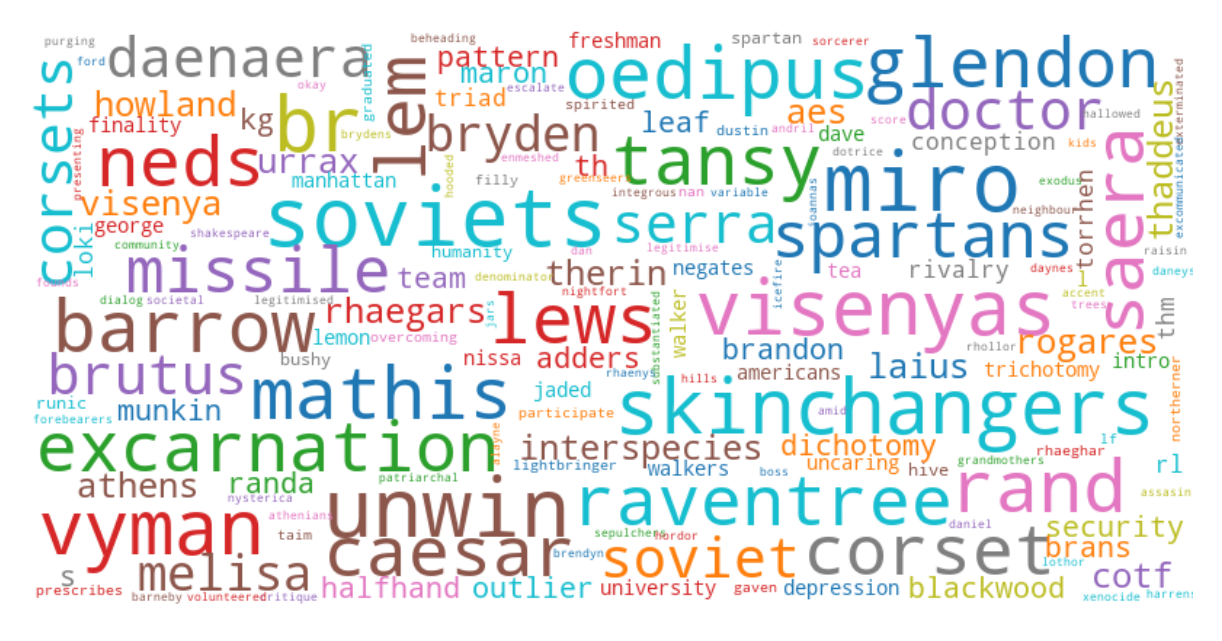

<Figure size 1800x1200 with 0 Axes>

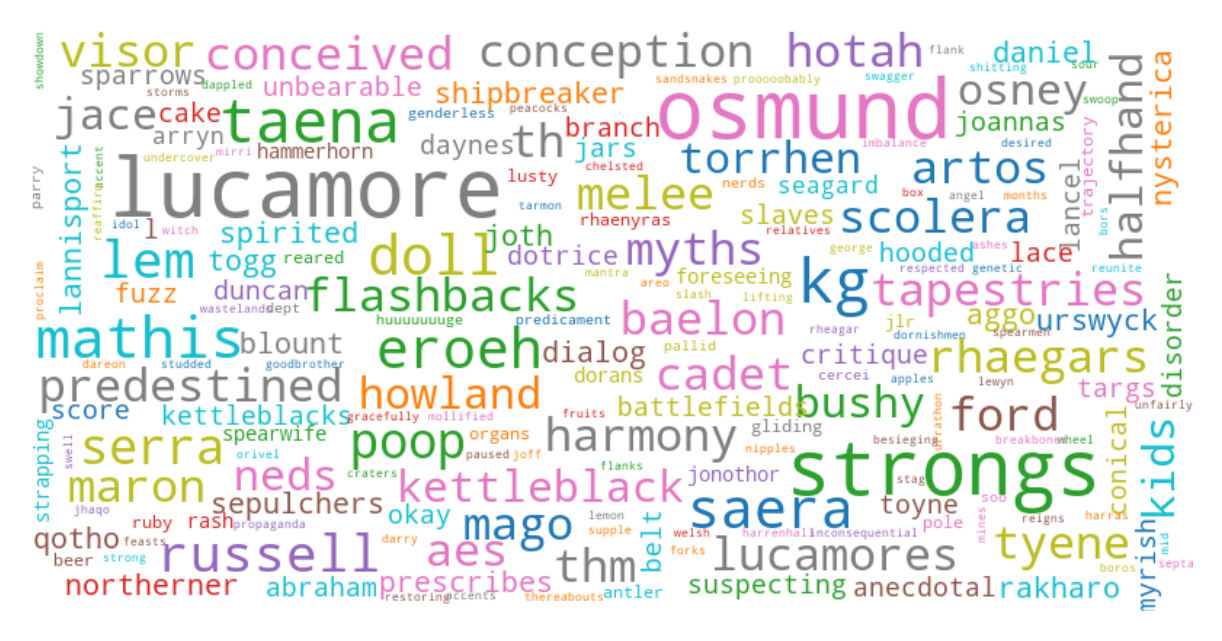

<Figure size 1800x1200 with 0 Axes>

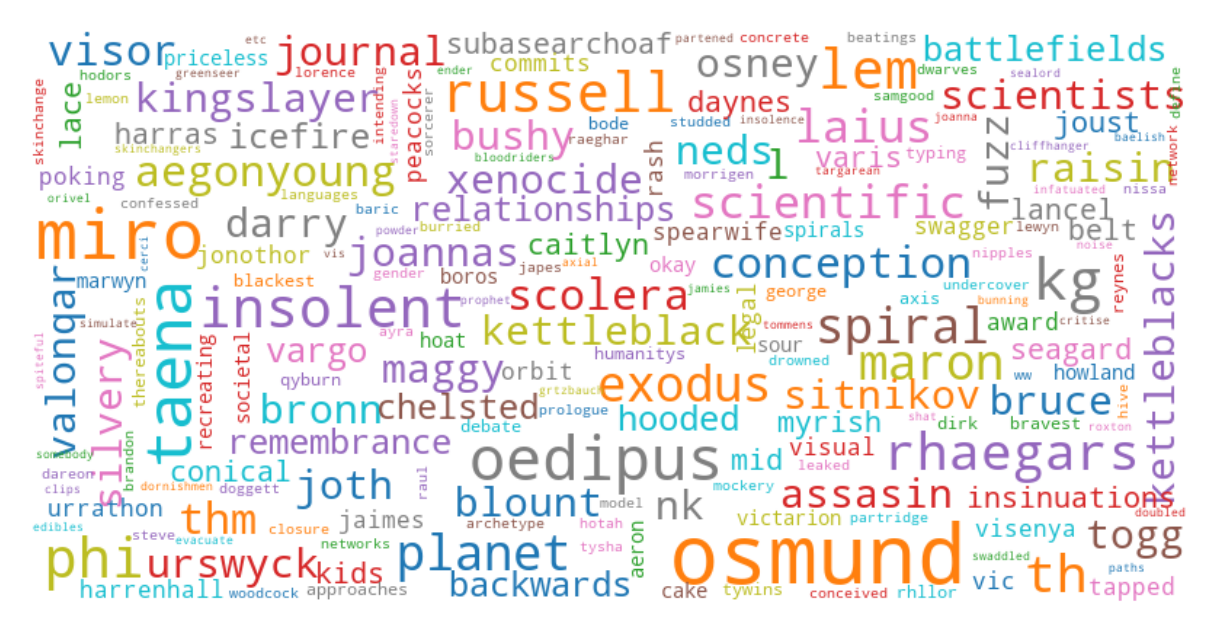

<Figure size 1800x1200 with 0 Axes>

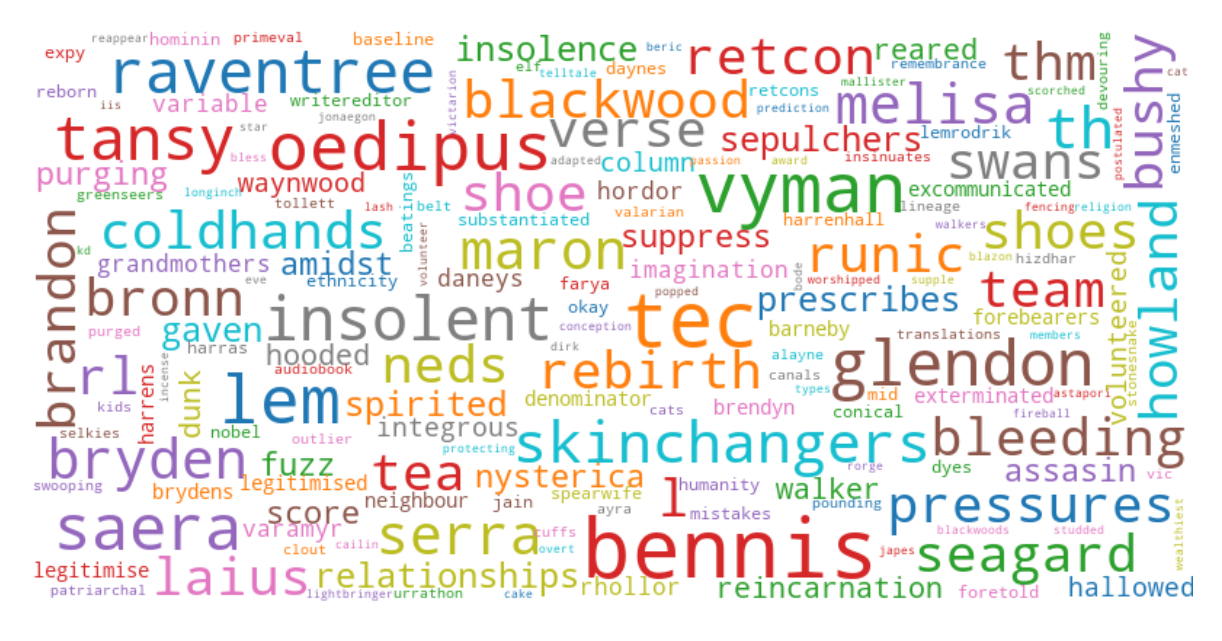

<Figure size 1800x1200 with 0 Axes>

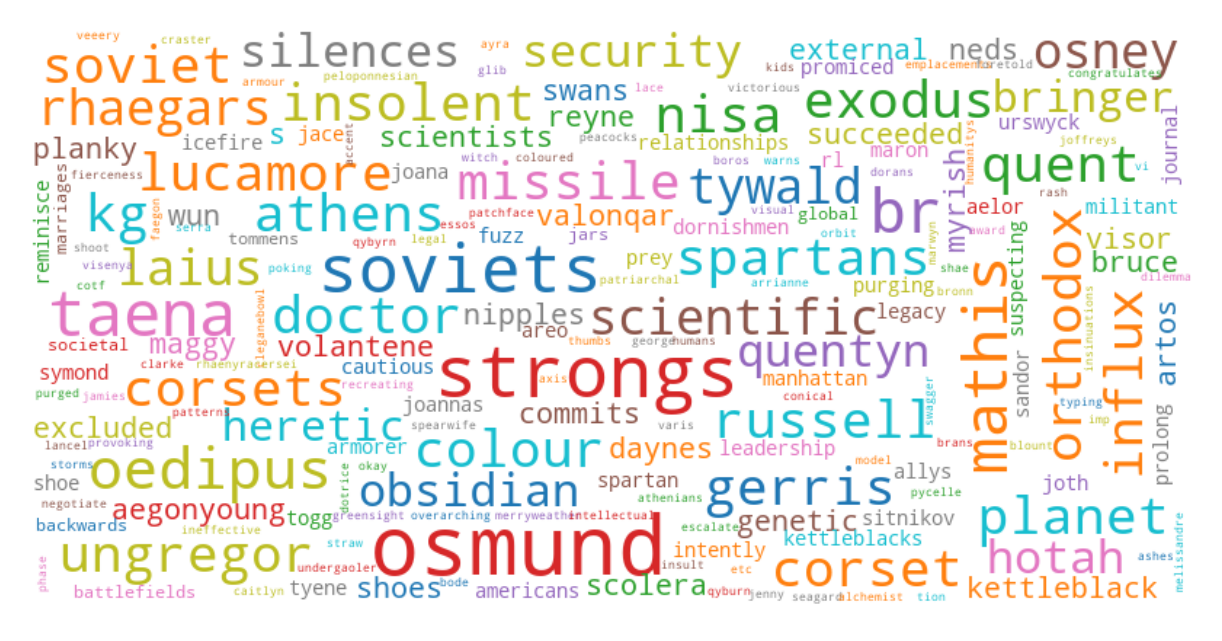

<Figure size 1800x1200 with 0 Axes>

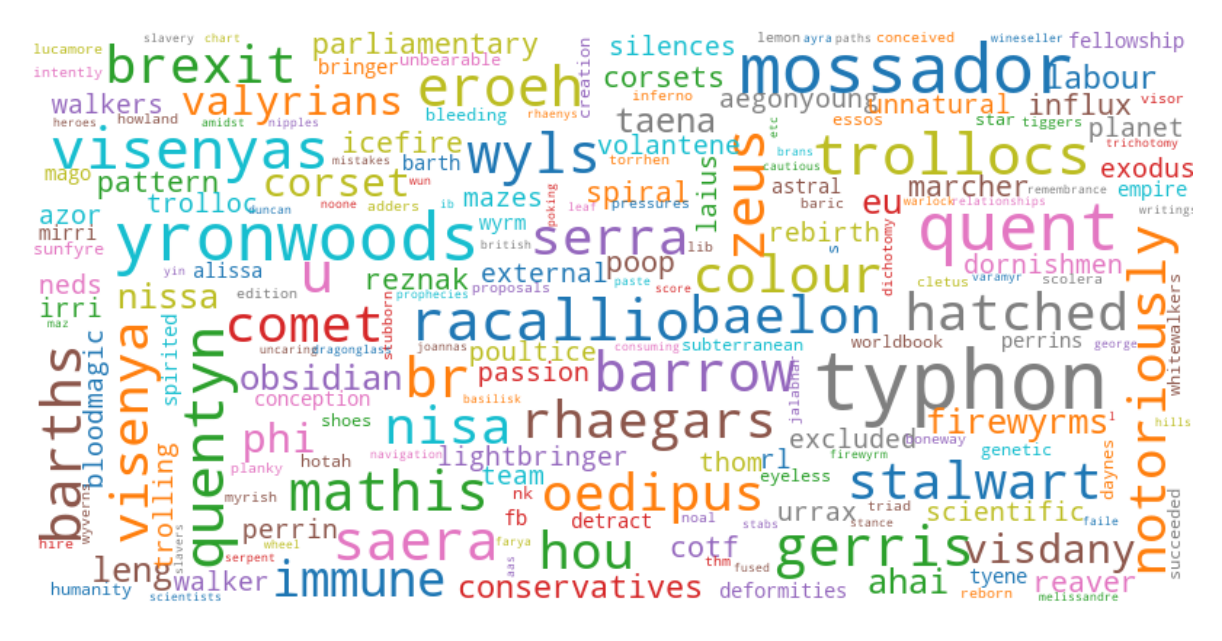

<Figure size 1800x1200 with 0 Axes>

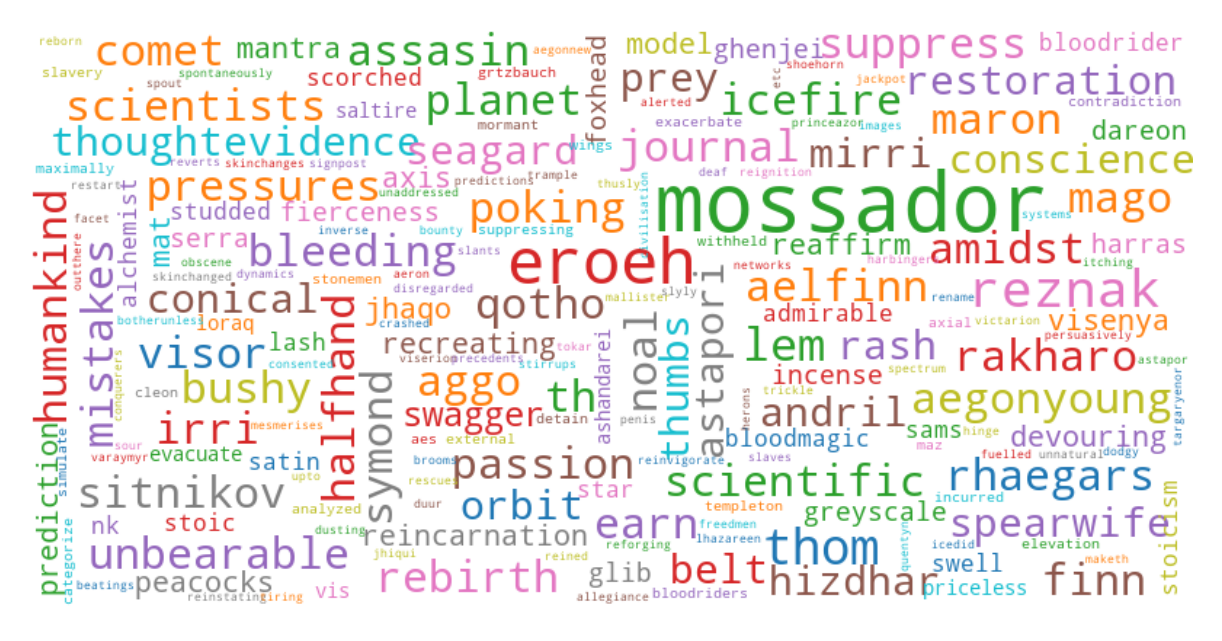

<Figure size 1800x1200 with 0 Axes>

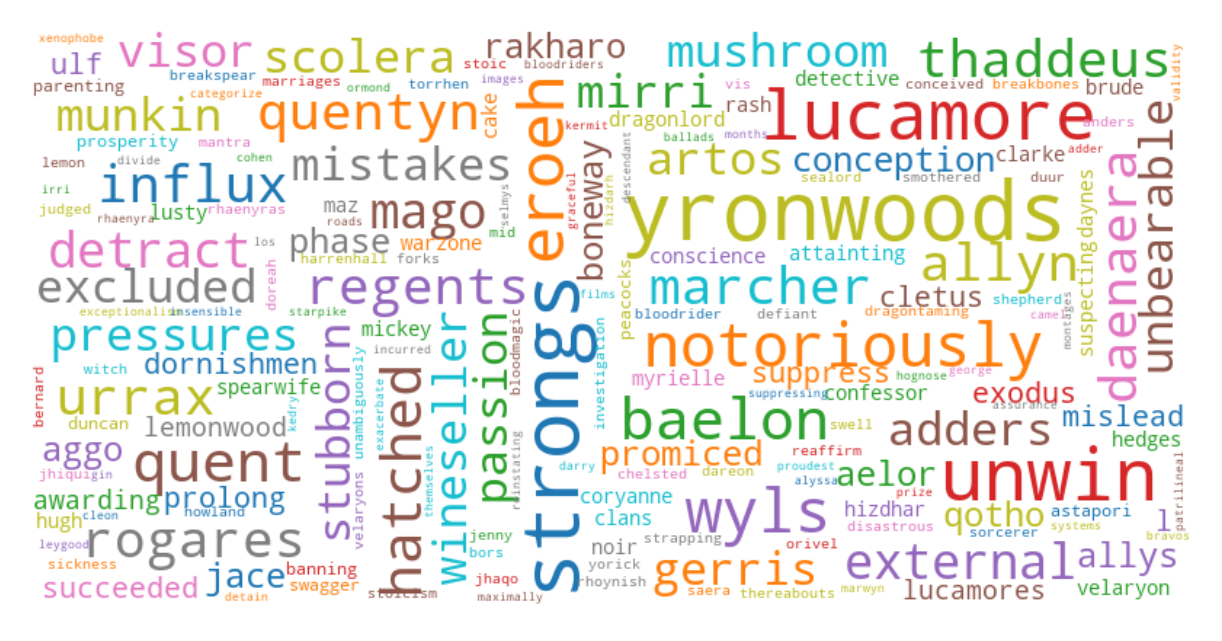

<Figure size 1800x1200 with 0 Axes>

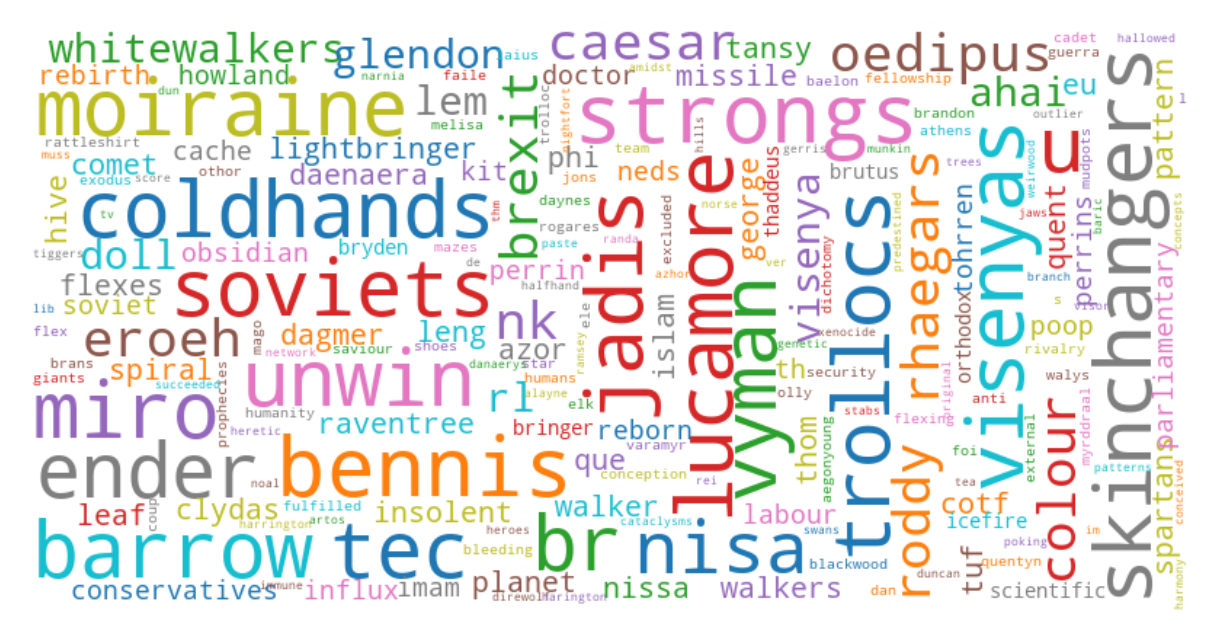

<Figure size 1800x1200 with 0 Axes>

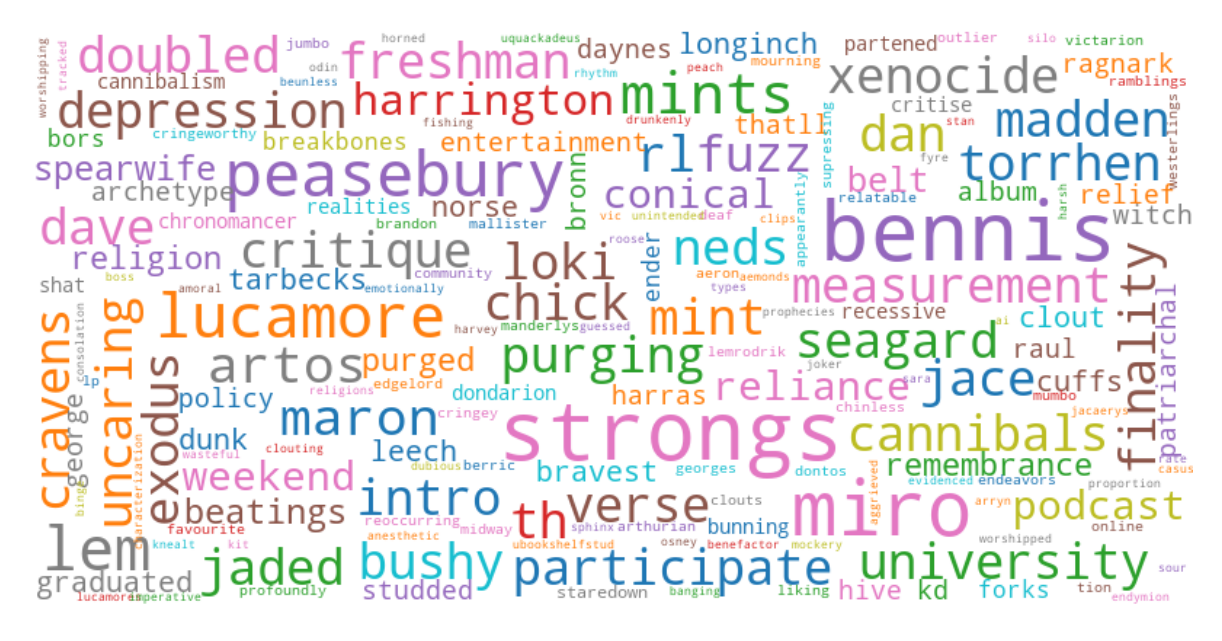

<Figure size 1800x1200 with 0 Axes>

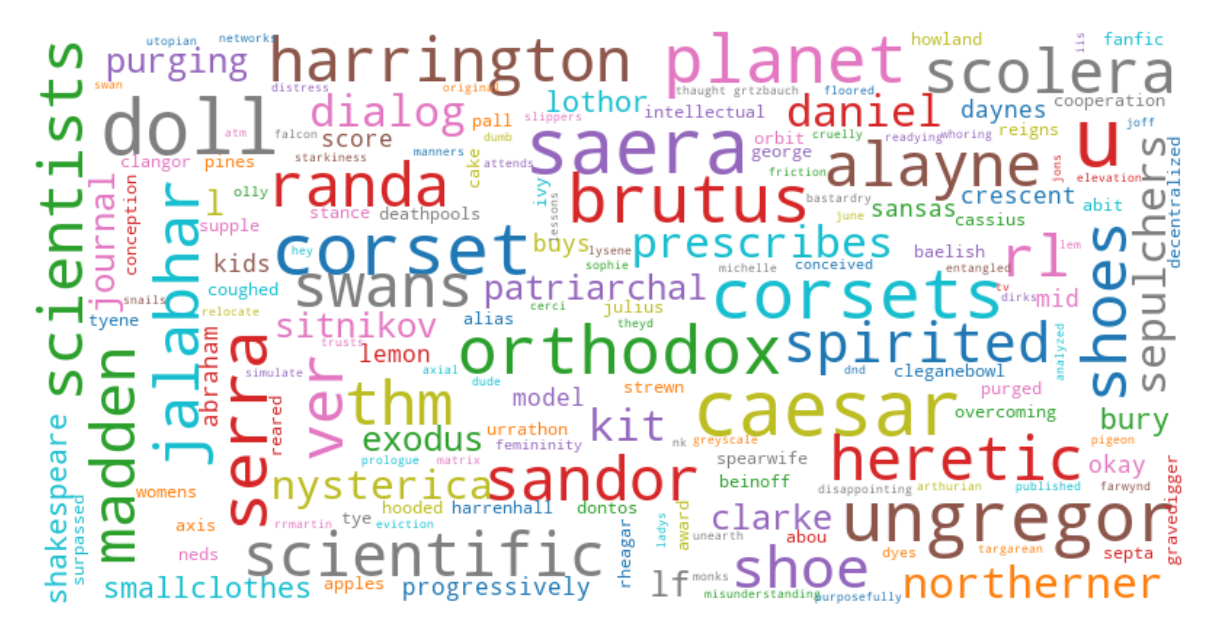

In [ ]:
for name in chosen:
    wordcloud = WordCloud(
        max_font_size=28.5,
        scale = 2,
        background_color="white",
        colormap = "tab10",
    ).generate_from_frequencies(doc_tf_idf[name])
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.savefig("../data/" + f'{name}_wordcloud.png')
    